In [232]:
import pandas as pd
import numpy as np
from itertools import combinations
from poker_utils.constants import HANDS_DICT
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [233]:
def process_base_hand_data(path_to_data: str) -> pd.DataFrame:
    raw_hand_data = pd.read_csv(path_to_data)
    raw_hand_data = raw_hand_data.rename(columns={
        'equity.flop': 'flop_equity',
        'equity.turn': 'turn_equity',
        'equity.river': 'river_equity'})
    raw_hand_data = raw_hand_data.assign(
        equity_delta=raw_hand_data['river_equity']-raw_hand_data['flop_equity']
        )
    # raw_hand_data.set_index("hand_idx", inplace=True)
    # raw_hand_data.index.name = "hand"
    return raw_hand_data[
        ['hand','connectedness','suited','pair','flop_equity','turn_equity','river_equity','equity_delta']
        ]

    

In [234]:
ev_data = pd.read_csv("data/raw/ev_pca_data.csv").set_index('hand')
dom_block_data = pd.read_csv("data/raw/dom_block_data.csv").set_index('hand')
hand_data = process_base_hand_data("data/raw/hand_data.csv")
hand_data['high_card'] = hand_data['hand'].apply(lambda x: '23456789TJQKA'.index(x[0]))
hand_data['low_card'] = hand_data['hand'].apply(lambda x: '23456789TJQKA'.index(x[1]))
hand_data['hand_type'] = np.select(
    condlist=[
        (hand_data['pair'] == True),
        (hand_data['suited'] == False),
        (hand_data['suited'] == True),
    ],
    choicelist=['pair', 'offsuit', 'suited'],
    default='other'
)
hand_data.set_index("hand", inplace=True)

In [235]:
full_data = pd.concat([hand_data, dom_block_data, ev_data], axis=1)

In [236]:
pc_cols = ['dom_block_pc1','dom_block_pc2','ev_pc1','ev_pc2']

In [237]:
X = full_data[
    ['high_card','low_card', 'hand_type', 'connectedness','flop_equity','turn_equity','river_equity','equity_delta']+
    ['ev_pc1', 'ev_pc2'] +
    ['dom_block_pc1', 'dom_block_pc2']
    ].copy()
X['hand_type'] = X['hand_type'].map({'pair': 0, 'suited': 1, 'offsuit': 2})

In [238]:

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [239]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

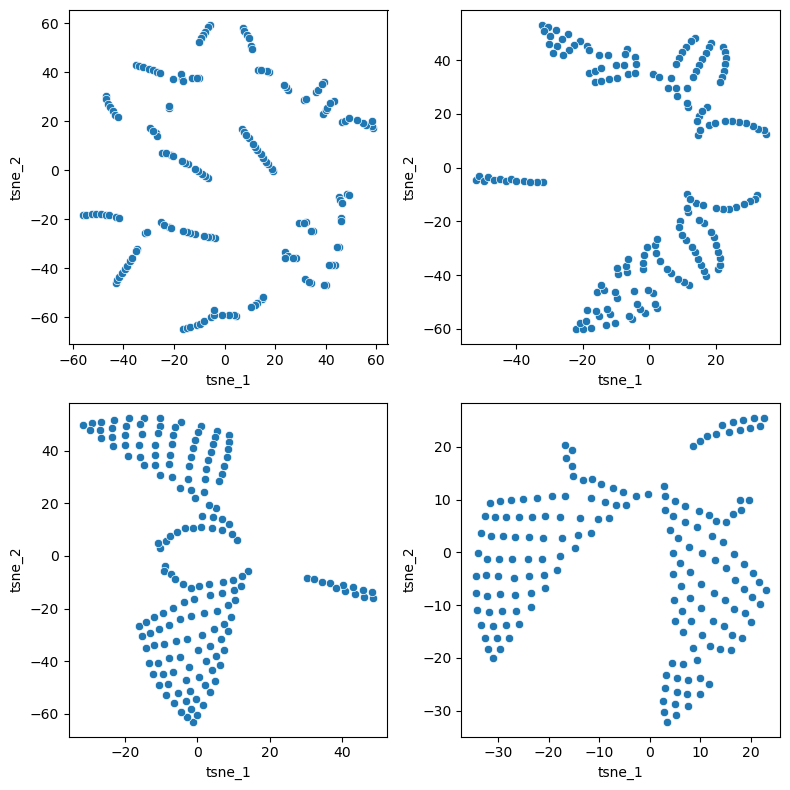

In [240]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
perplexities = [2,5,10,15]
for i, ax in enumerate(axs.flatten()):
    tsne = TSNE(n_components=2, random_state=29, perplexity=perplexities[i])
    X_tsne = tsne.fit_transform(X_scaled)
    X['tsne_1'] = X_tsne[:,0]
    X['tsne_2'] = X_tsne[:,1]
    sns.scatterplot(X, x='tsne_1', y='tsne_2', ax=ax)
plt.tight_layout()
plt.show()

In [241]:
tsne = TSNE(n_components=2, random_state=29, perplexity=10)
X_tsne = tsne.fit_transform(X_scaled)
X['tsne_1'] = X_tsne[:,0]
X['tsne_2'] = X_tsne[:,1]

In [242]:
from sklearn.cluster import KMeans

In [246]:
kmeans = KMeans(n_clusters=6, n_init=10, random_state=29)
clusters = kmeans.fit_predict(X[['tsne_1', 'tsne_2']])
X['cluster'] = clusters

c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


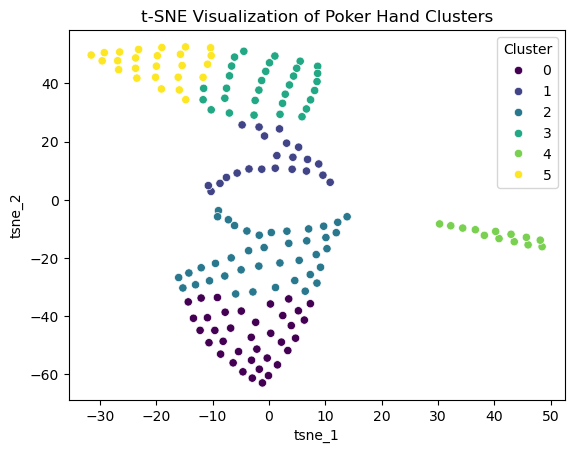

In [247]:
sns.scatterplot(data=X, x='tsne_1', y='tsne_2', hue='cluster', palette='viridis')
plt.title('t-SNE Visualization of Poker Hand Clusters')
plt.legend(title='Cluster')
plt.show()

In [245]:
X

,high_card,low_card,hand_type,connectedness,flop_equity,turn_equity,river_equity,equity_delta,ev_pc1,ev_pc2,dom_block_pc1,dom_block_pc2,tsne_1,tsne_2,cluster
hand,,,,,,,,,,,,,,,
22o,0,0,0,0,0.66276,0.58191,0.50212,-0.16064,-1.975724,-0.295287,-1.918918,-5.732989,48.489784,-16.100700,4
32o,1,0,2,1,0.22724,0.27272,0.32283,0.09559,-3.269981,-1.580486,4.424059,-1.179041,-31.539499,49.759689,5
32s,1,0,1,1,0.23654,0.29856,0.36030,0.12376,-3.695644,-0.605344,2.676905,-1.650385,-1.150364,-62.915096,0
33o,1,1,0,0,0.68989,0.61144,0.53494,-0.15495,-1.712806,0.104931,-2.068367,-5.558278,48.163502,-13.857657,4
42o,2,0,2,2,0.23643,0.28650,0.33435,0.09792,-2.833184,-1.567621,4.093049,-1.018717,-29.215624,50.578320,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T8o,8,6,2,2,0.46927,0.48532,0.50083,0.03156,-2.224811,-0.149369,0.120928,0.905164,-7.013873,29.845001,3
T8s,8,6,1,2,0.47939,0.50486,0.52672,0.04733,-0.176800,0.826443,-0.857422,0.532025,6.449257,-31.393431,2
T9o,8,7,2,1,0.47745,0.49630,0.51031,0.03286,-1.723222,0.645522,-0.210082,1.065488,-4.756084,25.755392,1
